## Precinct 21 voters maps

My goal was to analyze the voters in precinct 21: specifically, what addresses don't have recorded votes.

I downloaded some data from the [Durham ArcGIS server](http://gisweb2.durhamnc.gov/ArcGIS/rest/services/PublicWorks/PublicWorks/MapServer).

Here is an example of the fields that each record has: [record 1](http://gisweb2.durhamnc.gov/ArcGIS/rest/services/PublicWorks/PublicWorks/MapServer/89/1)

Note: I use the form `test -f file || get file` to prevent re-running commands. You can delete the files to redownload.

In [314]:
!test -f Precincts.shp || ( wget https://s3.amazonaws.com/dl.ncsbe.gov/PrecinctMaps/SBE_PRECINCTS_20161004.zip && unzip SBE_PRECINCTS_20161004.zip )

--2017-03-24 12:33:51--  https://s3.amazonaws.com/dl.ncsbe.gov/PrecinctMaps/SBE_PRECINCTS_20161004.zip
Resolving s3.amazonaws.com... 54.231.120.26
Connecting to s3.amazonaws.com|54.231.120.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19254674 (18M) [application/octet-stream]
Saving to: ‘SBE_PRECINCTS_20161004.zip’

SBE_PRECINCTS_20161 100%[===================>]  18.36M  6.85MB/s    in 2.7s    

2017-03-24 12:33:54 (6.85 MB/s) - ‘SBE_PRECINCTS_20161004.zip’ saved [19254674/19254674]

Archive:  SBE_PRECINCTS_20161004.zip
  inflating: Precincts.dbf           
  inflating: Precincts.prj           
  inflating: Precincts.shp           
  inflating: Precincts.shp.xml       
  inflating: Precincts.shx           


In [315]:
!test -f precinct-21.shp || ogr2ogr -sql "select * from Precincts where COUNTY_NAM='DURHAM' and PREC_ID='21'" -t_srs EPSG:4326 precinct-21.shp Precincts.shp

In [316]:
!ogr2ogr -f geojson precinct-21.geojson precinct-21.shp

After I got the boundary of the precinct 21 voting disrict above, I fetched all the property boundaries from the Durham GIS server.

There are a lot of properties that are not residential, so I filter these out too:

In [317]:
!test -f landuse.json || curl "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/89/query?f=json&geometry=%7B%22ymax%22:832470.521274,%22xmax%22:2032594.388967,%22ymin%22:824305.219035,%22xmin%22:2027901.245138%7D&returnGeometry=false&outFields=SITE_ADDRE,OWNER_NAME,LANDUSE_DESC,LAND_USE" > landuse.json

In [318]:
!jq '.features|.[]|.attributes.LANDUSE_DESC' landuse.json | sort | uniq -c | sort -n | tail -20

   3 "CMNTY SVC/ SCHOOL        "
   3 "COM/ APARTMENT-GARDEN    "
   3 "COM/ CONV STORE W/ GAS   "
   3 "COM/ OFFICE BLDG         "
   3 "COM/ PARKING LOTS-SURFACE"
   3 "COM/ WHSE-STORAGE        "
   3 "VAC RES/ LOT-SML TR/SIDE "
   4 "COM/ 1-STY SM SGL USER   "
   4 "COM/ AUTO BODY-TIRE      "
   4 "COM/ FAST FOOD           "
   5 "COM/ MULTI-USE CAPABLE   "
   7 "COM/ CONVERTED RESIDENCE "
   7 "VAC RES/ LOT-SML TR/REAR "
   8 "COM/ 1-STY SM MULTI USER "
  15 "WILD/ PARKS & REC - CITY "
  19 "VACANT COMMERCIAL        "
  27 "VACANT COMMUNITY SERVICE "
  30 "VAC RES/ LOT-SML TRACT   "
  42 "RES/ 2-FAMILY            "
 769 "RES/ 1-FAMILY            "


In [319]:
!jq '.features|.[]|.attributes.LANDUSE_DESC' landuse.json | grep 'RES' | sort | uniq -c | sort -n

   1 "COM/ RESTAURANTS         "
   1 "RES/ RESIDENTIAL (UNDIFF)"
   1 "RES/ TOWNHOUSE W/ LAND   "
   1 "VAC RES/ DEVELOPER       "
   2 "RES/ MULTIPLE DWG'S      "
   3 "VAC RES/ LOT-SML TR/SIDE "
   7 "COM/ CONVERTED RESIDENCE "
   7 "VAC RES/ LOT-SML TR/REAR "
  30 "VAC RES/ LOT-SML TRACT   "
  42 "RES/ 2-FAMILY            "
 769 "RES/ 1-FAMILY            "


I used paw to mess with the HTTP params, but generally I just added the `"RES` filter above to my curl request. Note that ArcGIS does not create geojson out of the box. I used the ogr2ogr tool to convert it ([thanks SO](http://gis.stackexchange.com/questions/13029/converting-arcgis-server-json-to-geojson)).

But what I really want is everything within the precinct 21 area, so I need to make an intersection with the precinct boundary to filter out non-precinct properties.

The Durham GIS server has a limit to how many records you can download in one request. To avoid this exceededTransferLimit error, I batch the requests in chunks.

In [320]:
import json
import os
import requests

all_lots_url = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/89/query?f=json&geometry=%7B%22ymax%22:832470.521274,%22xmax%22:2032594.388967,%22ymin%22:824305.219035,%22xmin%22:2027901.245138%7D&returnGeometry=true&outSR=4326&outFields=*"
# residential addresses - but some 'non residentials' still have voters:
# res_lots_url = "{}&where=LANDUSE_DESC%20like%20%27RES%25%27".format(all_lots_url)
res_lots_url = "{}&where=LANDUSE_DESC%20like%20%27%25RES%25%27".format(all_lots_url)

# non Durham properties:
# res_lots_url = "{}&where=lower(OWNER_NAME)%20not%20like%20%27%25durham%25%27".format(all_lots_url)

def strip_features(data):
    for row in data['features']:
        for k,v in row['attributes'].items():
            if isinstance(v, str):
                row['attributes'][k] = v.strip()
    return data

def download_arcgis(url, filename):   
    ids_request = requests.get("{}&returnIdsOnly=true".format(url))
    ids = ids_request.json()
    id_chunks = [ids['objectIds'][x:x+150] for x in range(0, len(ids['objectIds']), 150)]

    first_data = None
    for chunk in id_chunks:
        chunk_url = "{}&objectIds={}".format(url, ','.join(str(c) for c in chunk))
        data_request = requests.get(chunk_url)
        data = data_request.json()
        if first_data is None:
            first_data = strip_features(data)
        else:
            first_data['features'].extend(strip_features(data)['features'])

    jsonfile = '{}.json'.format(filename)
    with open(jsonfile,'w') as outfile:
        json.dump(first_data, outfile)        
        
if not os.path.exists('lots.json'):
    download_arcgis(res_lots_url, 'lots')
    !rm -f lots.geojson && ogr2ogr -f GeoJSON lots.geojson lots.json OGRGeoJSON
    !rm -f lots.shp && ogr2ogr lots.shp lots.geojson

if not os.path.exists('all_lots.json'):
    download_arcgis(all_lots_url, 'all_lots')
    !rm -f all_lots.geojson && ogr2ogr -f GeoJSON all_lots.geojson all_lots.json OGRGeoJSON
    !rm -f all_lots.shp && ogr2ogr all_lots.shp all_lots.geojson

In [321]:
import geopandas as gpd

lots = gpd.GeoDataFrame.from_file("lots.shp")
precinct = gpd.GeoDataFrame.from_file("precinct-21.shp")

print('Properties from arcgis: {}'.format(len(lots)))

lots = lots.to_crs({'init': 'epsg:4326'})
precinct = precinct.to_crs({'init': 'epsg:4326'})

lots_in_precinct = gpd.sjoin(lots, precinct, op='within')

print('Properties in precinct 21: {}'.format(len(lots_in_precinct)))

lots_in_precinct.to_file('precinct-21-lots.shp')

Properties from arcgis: 1272
Properties in precinct 21: 1072

In [322]:
!rm -f precinct-21-lots.geojson && ogr2ogr -f geojson precinct-21-lots.geojson precinct-21-lots.shp

## Residential Addresses in Princinct 21

In [323]:
import folium

map = folium.Map(location=[36.025, -78.899], tiles='CartoDB positron', zoom_start=15)
map.choropleth(geo_path='precinct-21-lots.geojson')
map.choropleth(geo_path='precinct-21.geojson', fill_opacity=0.2, line_opacity=0)
map

In [308]:
import pandas as pd

voters = pds.read_csv('ncvoter32.txt', sep=None)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [309]:
# voters_in_precinct21.dtypes
# pd.value_counts()
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

While messing around with this data, I did notice a strict "only RES" top level category properties left some gaps in neighborhoods, which didn't seem right. I settled on a looser "anything with RES" in the category description.

From the map below you can see we get a couple weird extras that maybe ought to be filtered out: "VAC RES", "CONVERTED RESIDENCE".

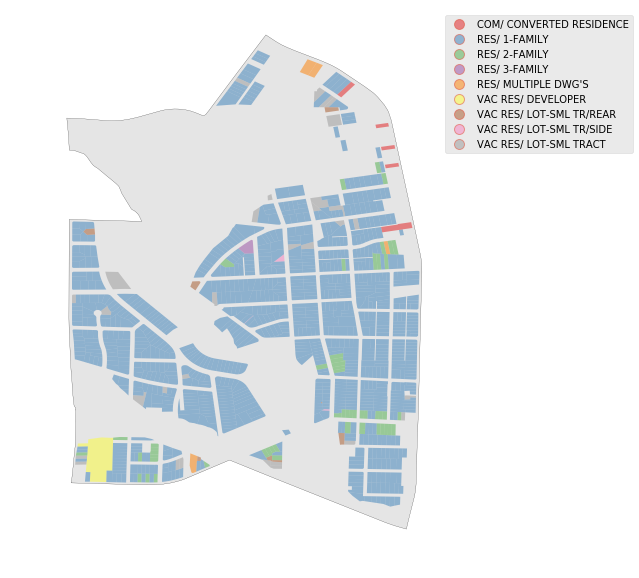

In [324]:
import geopandas as gpd

all_lots_pd = gpd.read_file('precinct-21-lots.shp')
precinct_boundary_pd = gpd.read_file('precinct-21.shp')

fig, ax = plt.subplots(1, figsize=(7,10))
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
all_lots_pd.plot(ax=ax, column='LANDUSE_DE', linewidth=0, legend=True)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.0, 0.0))

## Properties with no voters

Finally, joining the ArcGIS data to the we get a sense of what areas could use some voter outreach.

# Addresses w/o registered voter: 252


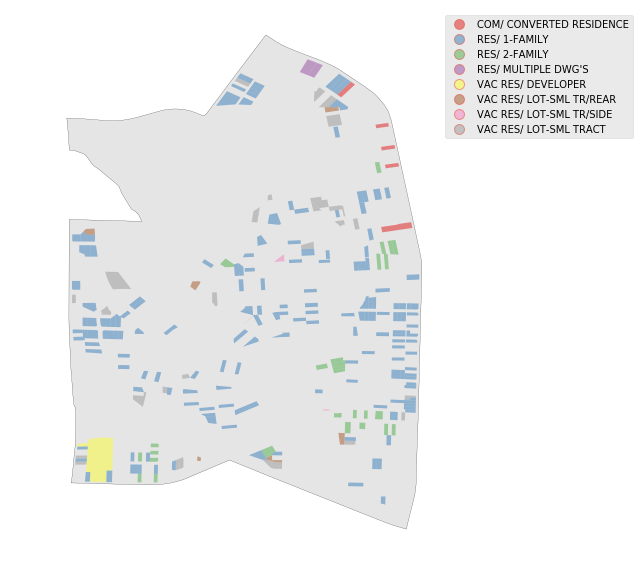

In [367]:
# so now that I have a shapefile of residential addresses, lets make files of addresses
# with no voters:

lot_attribs = [d['attributes'] for d in first_data['features']]
lot_attribs_df = pd.DataFrame(lot_attribs)

non_voters_pd = all_lots_pd.query('SITE_ADDRE not in @voters_in_precinct21.mail_addr1')

fig, ax = plt.subplots(1, figsize=(7,10))
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
non_voters_pd.plot(ax=ax, column='LANDUSE_DE', linewidth=0, legend=True)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.0, 0.0))
print("# Addresses w/o registered voter: {}".format(len(non_voters_pd)))

Voter breakdown:


DEM    942
UNA    474
REP    125
LIB      5
Name: party_cd, dtype: int64

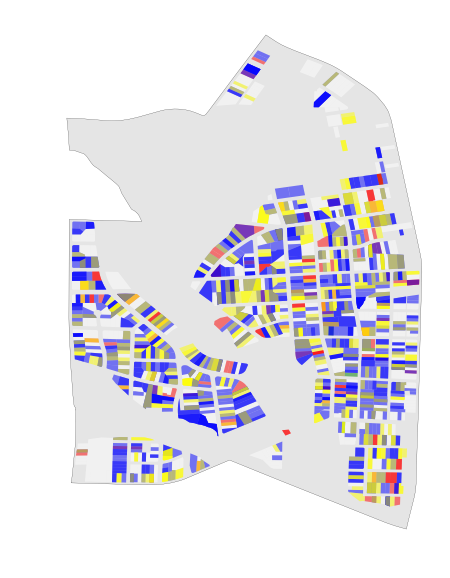

In [393]:
# and by party. Note that some places are super blue/red (all blue/red voters in the house).
# Purple for mixed houses, etc.

voters_pd = all_lots_pd.merge(voters_in_precinct21,left_on='SITE_ADDRE',right_on='mail_addr1')

colors = {
    'DEM': 'blue',
    'LIB': 'green',
    'REP': 'red',
    'UNA': 'yellow'
}

fig, ax = plt.subplots(1, figsize=(7,10))
ax.axis('off')

precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
non_voters_pd.plot(ax=ax, color='white', alpha=0.5, linewidth=0)

for k,v in colors.items():
    voters_pd[voters_pd.party_cd==k].plot(
        ax=ax, column='party_cd', linewidth=0, alpha=0.5, color=v
    )

print("Voter breakdown:")
voters_pd['party_cd'].value_counts()

In [379]:
avg_voters_per_address = voters_pd.groupby('mail_addr1')
avg_voters_per_address.size().describe()

count    818.000000
mean       1.889976
std        0.937520
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        7.000000
dtype: float64

In [392]:
# Given the average number of voters in any given house of registered voters, we could
# predict that each address with no voters registered NOW, might yield that average if
# one knocked on their door:

untapped = int(avg_voters_per_address.size().describe()['mean'] * len(non_voters_pd))
dems = voters_pd['party_cd'].value_counts()['DEM']

print('Potential untapped voters: {}'.format(untapped))
print('Potential untapped Dems:   {}'.format(int(untapped * dems/len(voters_pd))))

Potential untapped voters: 476
Potential untapped Dems:   290
